In [4]:
import torch
from model import GPT, GPTConfig

main_device = 'cuda:0'

# Define the configuration for the GPT model
config = GPTConfig(
    n_experts = 20,
    top_k = 4,
    main_device = main_device
)

# Initialize the model
model = GPT(config)
model.to(main_device)

# Generate some random input data
input_ids = torch.randint(0, config.vocab_size, (1, 4))  # batch size 1, sequence length 10

# Set the model to evaluation mode
model.eval()

# Generate text
with torch.no_grad():
    generated_ids = model.generate(input_ids.to(main_device), max_new_tokens=20)

# Print the generated text (as token IDs)
print("Generated token IDs:", generated_ids)

number of parameters: 1200.59M
Generated token IDs: tensor([[19199, 10108,   365,  3845, 47389, 34876, 49916,  1164, 46988, 20706,
         42041, 14269, 35615, 45757, 28640,  1947,  3853, 20106,  3734,  6407,
         23533, 47022, 48582, 41022]], device='cuda:0')


In [10]:
class TestDataset(torch.utils.data.Dataset):

    def __init__(self, tokens: dict):
        self.I = tokens['input_ids'].shape[0]
        self.N = tokens['input_ids'].shape[1]        
        self.tokens = tokens
        
    def __len__(self):
        return len(self.tokens['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx]
        }

In [15]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

In [16]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [41]:
from datasets import load_dataset
# use name="sample-10BT" to use the 10BT sample
dataset = load_dataset("HuggingFaceFW/fineweb-edu", name="sample-10BT", split="train", streaming=True)
examples = []
for i, datapoint in enumerate(dataset):
    examples.append(datapoint['text'])
    if i >= 999:
        break

train_ds = TestDataset(tokenizer(examples, truncation = True, max_length = 1024, padding = 'longest', return_tensors = 'pt').to(main_device))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 10, shuffle = False)

Resolving data files:   0%|          | 0/2080 [00:00<?, ?it/s]

tensor(1203, device='cuda:0')
tensor(993, device='cuda:0')
tensor(1912, device='cuda:0')
tensor(0, device='cuda:0')
tensor(933, device='cuda:0')
tensor(1179, device='cuda:0')
tensor(1385, device='cuda:0')
tensor(1564, device='cuda:0')
tensor(1441, device='cuda:0')
tensor(1853, device='cuda:0')
tensor(1423, device='cuda:0')
tensor(1564, device='cuda:0')
tensor(1896, device='cuda:0')
tensor(884, device='cuda:0')
tensor(853, device='cuda:0')
tensor(1553, device='cuda:0')
tensor(1410, device='cuda:0')
tensor(1545, device='cuda:0')
tensor(1769, device='cuda:0')
tensor(1565, device='cuda:0')
tensor(1911, device='cuda:0')
tensor(986, device='cuda:0')
tensor(1201, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1825, device='cuda:0')
tensor(1886, device='cuda:0')
tensor(1839, device='cuda:0')
tensor(1938, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1801, device='cuda:0')
tensor(1878, device='cuda:0')
tensor(1768, device='cuda:0')
tensor(1102, device='cuda:0')
tensor(1381, device='cud

(array([109.,   9.,   8.,  19.,  15.,  15.,  18.,  21.,  27.,  28.,  37.,
         46.,  42.,  58.,  76.,  85.,  92., 113.,  98.,  84.]),
 array([   0. ,   98.4,  196.8,  295.2,  393.6,  492. ,  590.4,  688.8,
         787.2,  885.6,  984. , 1082.4, 1180.8, 1279.2, 1377.6, 1476. ,
        1574.4, 1672.8, 1771.2, 1869.6, 1968. ]),
 <BarContainer object of 20 artists>)

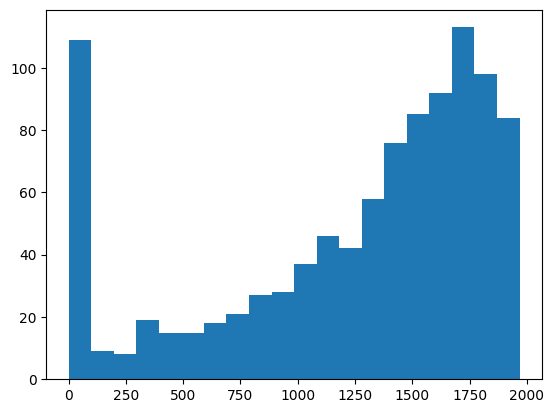

In [36]:
length = []
for i in range(len(train_ds)):
    # check how many padding tokens are in the input_ids
    print((train_ds[i]['input_ids'] == tokenizer.pad_token_id).sum())
    length.append((train_ds[i]['input_ids'] == tokenizer.pad_token_id).sum().item())
import matplotlib.pyplot as plt
plt.hist(length, bins = 20)
plt.show()
    

In [38]:
batch

{'input_ids': tensor([[50256, 50256, 50256,  ...,   286, 12157,    13],
         [50256, 50256, 50256,  ...,   711,  1342,    13],
         [50256, 50256, 50256,  ...,   290, 10953,    13],
         ...,
         [50256, 50256, 50256,  ...,   645, 21954,    13],
         [50256, 50256, 50256,  ...,   262,  4369,    13],
         [50256, 50256, 50256,  ...,    13,   471,    13]], device='cuda:0'),
 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]], device='cuda:0')}

In [42]:
import torch
from transformers import Trainer, TrainingArguments
from torch.utils.tensorboard import SummaryWriter


# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Define the data collator
def data_collator(features):
    input_ids = torch.stack([f['input_ids'] for f in features])
    attention_mask = torch.stack([f['attention_mask'] for f in features])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': input_ids}

# Initialize the Trainer
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_ds,                     
)

# Train the model
trainer.train()

Epoch 1/3:   0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Expected input batch_size (10) to match target batch_size (10240).